In [19]:
%run ../../Environment/environment.ipynb

Notebook ausgeführt


In [20]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import Counter

In [21]:
seed = 42
SEED  = seed % (2**32 - 1)
print(f"SEED: {SEED}")

SEED: 42


In [22]:
# -------------------------------
# CSV Daten einlesen
# -------------------------------
train_data = pd.read_csv("../../Transform_data/stand_data/2023-2018_stand_data.csv")
train_data.drop('datetime', axis=1, inplace=True)

test_data = pd.read_csv("../../Transform_data/stand_data/2025-2024_stand_data.csv")
test_data.drop('datetime', axis=1, inplace=True)

if train_data is not None and test_data is not None:
    print("Daten erfolgreich eingelesen")

Daten erfolgreich eingelesen


In [26]:
# Für Hyperparameter-Tuning nutzen wir test_data als Validierungsdatensatz.
valid_data = test_data.copy()

# -------------------------------
# Evaluation Helper Function
# -------------------------------
def evaluate_agent(model, env, n_eval_episodes=5):
    """
    Evaluate the model over a number of episodes.
    Returns the average cumulative reward.
    """
    episode_rewards = []
    for _ in range(n_eval_episodes):
        # Handle reset return for compatibility with gym vs. gymnasium APIs
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            obs, info = reset_result
        else:
            obs = reset_result
        done = False
        total_reward = 0.0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            # Check length to handle different API outputs
            if len(step_result) == 5:
                obs, reward, done, truncated, info = step_result
            else:
                obs, reward, done, info = step_result
            total_reward += reward
        episode_rewards.append(total_reward)
    return np.mean(episode_rewards)

In [29]:
# -------------------------------
# Hyperparameter Tuning with Optuna
# -------------------------------
def objective(trial):
    # Sample hyperparameters using updated Optuna functions
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    
    # Create the training environment using train_data
    env_train = DummyVecEnv([lambda: TradingEnv(
        data=train_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../../Transform_data/scaler.pkl",
        default_seed=SEED
    )])
    
    # Create the validation environment using valid_data
    env_valid = DummyVecEnv([lambda: TradingEnv(
        data=valid_data,
        initial_cash=10_000,
        window_size=336,
        scaler_path="../../Transform_data/scaler.pkl",
        default_seed=SEED
    )])
    
    # Initialize the DQN model with sampled hyperparameters
    model = DQN(
        "MlpPolicy",
        env_train,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        verbose=0,
        seed=SEED,
        buffer_size=100_000
    )
    
    # Train the model for a fixed number of timesteps
    model.learn(total_timesteps=5000, log_interval=1)
    
    # Evaluate the trained model on the validation environment
    mean_reward = evaluate_agent(model, env_valid, n_eval_episodes=5)
    return mean_reward

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_trial.params)

[I 2025-03-09 23:30:29,499] A new study created in memory with name: no-name-9fcddb1a-18ff-4107-a750-ee4edae8bbf4


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:30:54,781] Trial 0 finished with value: -6.70742654800415 and parameters: {'learning_rate': 0.001913649674771593, 'gamma': 0.9760541516279864, 'batch_size': 32}. Best is trial 0 with value: -6.70742654800415.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:31:21,311] Trial 1 finished with value: -0.38000503182411194 and parameters: {'learning_rate': 0.0004454010887905035, 'gamma': 0.9517568623401085, 'batch_size': 32}. Best is trial 1 with value: -0.38000503182411194.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:31:47,277] Trial 2 finished with value: -7.925814628601074 and parameters: {'learning_rate': 3.441108106131243e-05, 'gamma': 0.9351236163969382, 'batch_size': 64}. Best is trial 1 with value: -0.38000503182411194.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:32:16,052] Trial 3 finished with value: -1.9598829746246338 and parameters: {'learning_rate': 6.57078641283958e-05, 'gamma': 0.9287276940193335, 'batch_size': 128}. Best is trial 1 with value: -0.38000503182411194.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:32:42,542] Trial 4 finished with value: -0.2501571774482727 and parameters: {'learning_rate': 0.0005477890515215763, 'gamma': 0.903927605649188, 'batch_size': 32}. Best is trial 4 with value: -0.2501571774482727.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:33:09,197] Trial 5 finished with value: -5.954848766326904 and parameters: {'learning_rate': 6.806184554888373e-05, 'gamma': 0.9889042946852235, 'batch_size': 64}. Best is trial 4 with value: -0.2501571774482727.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:33:35,370] Trial 6 finished with value: -6.299469947814941 and parameters: {'learning_rate': 0.0019349716411321202, 'gamma': 0.9902407262692607, 'batch_size': 32}. Best is trial 4 with value: -0.2501571774482727.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:34:00,675] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.004295139082437678, 'gamma': 0.9746127817052296, 'batch_size': 32}. Best is trial 7 with value: 0.0.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:34:27,522] Trial 8 finished with value: -7.08658504486084 and parameters: {'learning_rate': 2.5133303319978727e-05, 'gamma': 0.9273582557654478, 'batch_size': 64}. Best is trial 7 with value: 0.0.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:34:54,358] Trial 9 finished with value: -9.952998161315918 and parameters: {'learning_rate': 0.00018338903767535944, 'gamma': 0.9607396952000943, 'batch_size': 64}. Best is trial 7 with value: 0.0.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:35:26,903] Trial 10 finished with value: 0.020835597068071365 and parameters: {'learning_rate': 0.006684974743872794, 'gamma': 0.9691109942486473, 'batch_size': 256}. Best is trial 10 with value: 0.020835597068071365.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:35:59,350] Trial 11 finished with value: -7.533076286315918 and parameters: {'learning_rate': 0.009150411393711137, 'gamma': 0.9666559357950156, 'batch_size': 256}. Best is trial 10 with value: 0.020835597068071365.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:36:29,943] Trial 12 finished with value: -0.015364011749625206 and parameters: {'learning_rate': 0.008110210426512372, 'gamma': 0.9771179145118983, 'batch_size': 256}. Best is trial 10 with value: 0.020835597068071365.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:37:01,516] Trial 13 finished with value: -7.14644718170166 and parameters: {'learning_rate': 0.0021731980747276753, 'gamma': 0.999858753902282, 'batch_size': 256}. Best is trial 10 with value: 0.020835597068071365.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:37:29,690] Trial 14 finished with value: -7.51400899887085 and parameters: {'learning_rate': 0.004418493661888087, 'gamma': 0.9467409970045335, 'batch_size': 128}. Best is trial 10 with value: 0.020835597068071365.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:38:02,119] Trial 15 finished with value: 0.8339570760726929 and parameters: {'learning_rate': 0.0012485506477928228, 'gamma': 0.9734721381812269, 'batch_size': 256}. Best is trial 15 with value: 0.8339570760726929.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:38:34,005] Trial 16 finished with value: 1.0548583269119263 and parameters: {'learning_rate': 0.0008676988081645593, 'gamma': 0.9567540210286709, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:39:08,225] Trial 17 finished with value: -6.9507341384887695 and parameters: {'learning_rate': 0.0010856725788831079, 'gamma': 0.9492133058780281, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:39:43,468] Trial 18 finished with value: -7.001706123352051 and parameters: {'learning_rate': 0.0002037133482086702, 'gamma': 0.9100669877503913, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:40:20,571] Trial 19 finished with value: -5.972936153411865 and parameters: {'learning_rate': 0.0007090604386343064, 'gamma': 0.95797755999512, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:40:55,486] Trial 20 finished with value: 0.3945876359939575 and parameters: {'learning_rate': 0.0002684446633455608, 'gamma': 0.9385204584403846, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:41:30,252] Trial 21 finished with value: -3.920353412628174 and parameters: {'learning_rate': 0.00021880288598615742, 'gamma': 0.9400228376583558, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:42:02,058] Trial 22 finished with value: -8.767446517944336 and parameters: {'learning_rate': 0.0010070301271135748, 'gamma': 0.9186036392016369, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:42:33,644] Trial 23 finished with value: -1.3228282928466797 and parameters: {'learning_rate': 0.0002965780657608745, 'gamma': 0.9408146808150024, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:43:03,466] Trial 24 finished with value: -1.689160943031311 and parameters: {'learning_rate': 9.861680106280602e-05, 'gamma': 0.957324837720737, 'batch_size': 128}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:43:36,614] Trial 25 finished with value: -0.042179934680461884 and parameters: {'learning_rate': 1.3996899252329601e-05, 'gamma': 0.9851557403891257, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:44:10,421] Trial 26 finished with value: -7.073974609375 and parameters: {'learning_rate': 0.0008920855151604088, 'gamma': 0.963433195791013, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:44:46,005] Trial 27 finished with value: -5.411808490753174 and parameters: {'learning_rate': 0.0003880029760329613, 'gamma': 0.9514959335221332, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:45:21,270] Trial 28 finished with value: -9.518563270568848 and parameters: {'learning_rate': 0.00011301046274343368, 'gamma': 0.9253738306493545, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:45:52,917] Trial 29 finished with value: -6.3683624267578125 and parameters: {'learning_rate': 0.0014699388517605643, 'gamma': 0.9756996686938655, 'batch_size': 128}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:46:27,463] Trial 30 finished with value: -0.4288042187690735 and parameters: {'learning_rate': 0.002734996129432956, 'gamma': 0.9419669261703325, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:47:02,658] Trial 31 finished with value: -7.752010345458984 and parameters: {'learning_rate': 0.004025346335979605, 'gamma': 0.9700025742650324, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:47:38,478] Trial 32 finished with value: -0.3045494556427002 and parameters: {'learning_rate': 0.0006049062145336176, 'gamma': 0.9815696434619444, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:48:14,759] Trial 33 finished with value: -6.015052795410156 and parameters: {'learning_rate': 0.0014191917656364923, 'gamma': 0.9684113027680836, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:48:48,223] Trial 34 finished with value: -4.83560848236084 and parameters: {'learning_rate': 0.00033355853169276465, 'gamma': 0.9342653062147704, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:49:14,932] Trial 35 finished with value: -7.497094631195068 and parameters: {'learning_rate': 0.0066283859987515, 'gamma': 0.9533023658580988, 'batch_size': 32}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:49:43,138] Trial 36 finished with value: -6.794527530670166 and parameters: {'learning_rate': 0.002683582313335808, 'gamma': 0.9632741547533742, 'batch_size': 64}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:50:16,753] Trial 37 finished with value: 0.2695690393447876 and parameters: {'learning_rate': 0.000648295821510168, 'gamma': 0.9705189163636746, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:50:44,262] Trial 38 finished with value: -0.7564762830734253 and parameters: {'learning_rate': 0.0004617595803771331, 'gamma': 0.9947186684458154, 'batch_size': 32}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:51:15,765] Trial 39 finished with value: -6.642302513122559 and parameters: {'learning_rate': 0.0007518457930770483, 'gamma': 0.9339891949356514, 'batch_size': 128}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:51:45,098] Trial 40 finished with value: -5.068713188171387 and parameters: {'learning_rate': 0.0001448560278645859, 'gamma': 0.9831409581793543, 'batch_size': 64}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:52:19,897] Trial 41 finished with value: 0.04529057815670967 and parameters: {'learning_rate': 0.0013150264193949567, 'gamma': 0.9718812014197594, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:52:55,635] Trial 42 finished with value: -5.299361705780029 and parameters: {'learning_rate': 0.0013357481012446738, 'gamma': 0.9726317915701733, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:53:30,618] Trial 43 finished with value: -1.035954475402832 and parameters: {'learning_rate': 0.0006217284146174775, 'gamma': 0.9792132948062249, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:54:06,069] Trial 44 finished with value: -5.740586757659912 and parameters: {'learning_rate': 0.00027754168612506276, 'gamma': 0.9563947344401748, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:54:36,016] Trial 45 finished with value: -6.471758842468262 and parameters: {'learning_rate': 0.0005301335790629884, 'gamma': 0.9646232852110531, 'batch_size': 32}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:55:09,688] Trial 46 finished with value: 0.611265242099762 and parameters: {'learning_rate': 0.0017876973723835521, 'gamma': 0.990136044486523, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:55:44,377] Trial 47 finished with value: -7.475866794586182 and parameters: {'learning_rate': 0.0021771226068552077, 'gamma': 0.9879342271696643, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:56:11,227] Trial 48 finished with value: 0.0 and parameters: {'learning_rate': 0.003335669133119358, 'gamma': 0.9952507902446671, 'batch_size': 64}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42
Seed in the environment: 42


[I 2025-03-09 23:56:44,844] Trial 49 finished with value: -4.2517242431640625 and parameters: {'learning_rate': 0.0016550686628537283, 'gamma': 0.9468522605049129, 'batch_size': 256}. Best is trial 16 with value: 1.0548583269119263.


Seed in the environment: 42
Best hyperparameters: {'learning_rate': 0.0008676988081645593, 'gamma': 0.9567540210286709, 'batch_size': 256}


In [31]:
# -------------------------------
# TradingEnv erstellen (Final Environment using train_data)
# -------------------------------
env = TradingEnv(
    data=train_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

if env is not None:
    print("Environment created successfully")

Seed in the environment: 42
Environment created successfully


In [32]:
# -------------------------------
# DQN-Agenten initialisieren using Best Hyperparameters
# -------------------------------
best_params = study.best_trial.params
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    seed=SEED,
    buffer_size=500_000,
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    batch_size=best_params["batch_size"]
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [33]:
# -------------------------------
# Training
# -------------------------------
model.learn(
    total_timesteps=10000, 
    log_interval=1
)

# Speichere das trainierte Modell
model.save("dqn_trading_model")

Seed in the environment: 42


Seed in the environment: 42


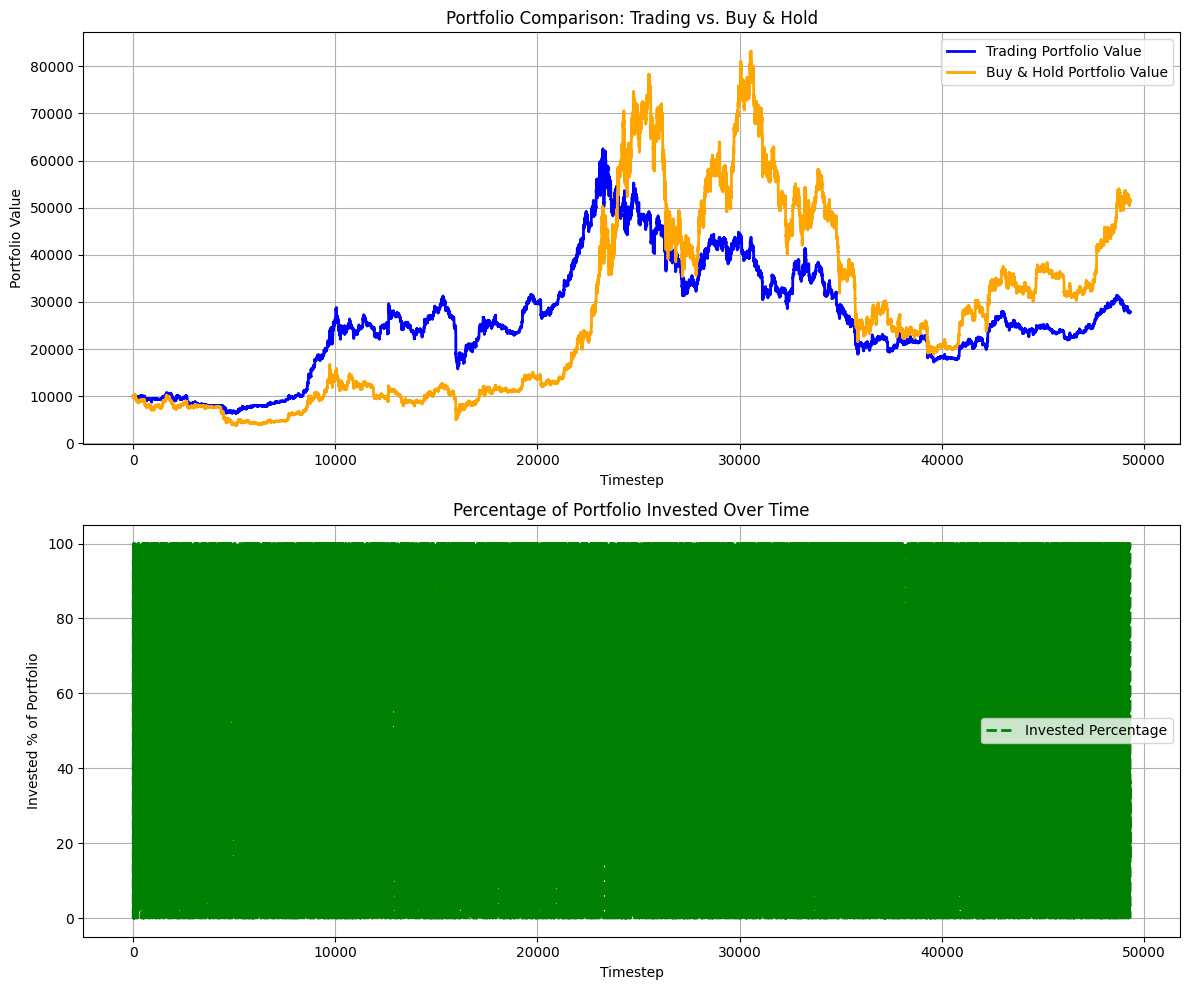

[0, 5, 0, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 3, 8, 8, 8, 8, 8, 7, 8, 8, 1, 4, 4, 4, 8, 3, 4, 4, 8, 3, 3, 8, 8, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 8, 8, 4, 8, 8, 1, 4, 8, 8, 8, 1, 1, 8, 8, 8, 1, 1, 8, 7, 4, 1, 8, 8, 8, 4, 8, 8, 8, 5, 8, 8, 7, 8, 6, 1, 8, 1, 1, 1, 1, 8, 8, 8, 8, 1, 8, 8, 8, 8, 1, 1, 8, 8, 8, 1, 1, 7, 7, 7, 7, 7, 7, 7, 1, 1, 6, 7, 8, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 7, 6, 7, 7, 6, 6, 6, 6, 6, 1, 7, 6, 1, 6, 6, 2, 7, 2, 3, 3, 7, 2, 1, 2, 2, 2, 1, 5, 5, 6, 2, 7, 7, 2, 2, 2, 2, 2, 1, 2, 6, 2, 2, 2, 2, 7, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 6, 8, 2, 7, 7, 2, 2, 7, 7, 2, 2, 2, 3, 6, 8, 2, 2, 7, 7, 2, 7, 2, 2, 1, 2, 2, 2, 6, 3, 3, 6, 6, 6, 6, 6, 2, 2, 1, 2, 2, 6, 4, 2, 4, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 3, 3, 1, 2, 2, 6, 2, 2, 2, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 7, 7, 2, 2, 7, 7, 2, 2, 2, 2, 2, 7, 7, 7, 0, 

In [34]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen (Training Environment)
# -------------------------------
training_env = env

reset_result = training_env.reset(seed=SEED)
if isinstance(reset_result, tuple):
    obs, info = reset_result
else:
    obs = reset_result
done = False

# Liste der Aktionen
action_list = []

while not done:
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    step_result = training_env.step(action)
    if len(step_result) == 5:
        obs, reward, done, truncated, info = step_result
    else:
        obs, reward, done, info = step_result
    action_list.append(action)

# Rendern des aktuellen Zustands (z.B. als Plot)
training_env.render(mode='human')
print(action_list)

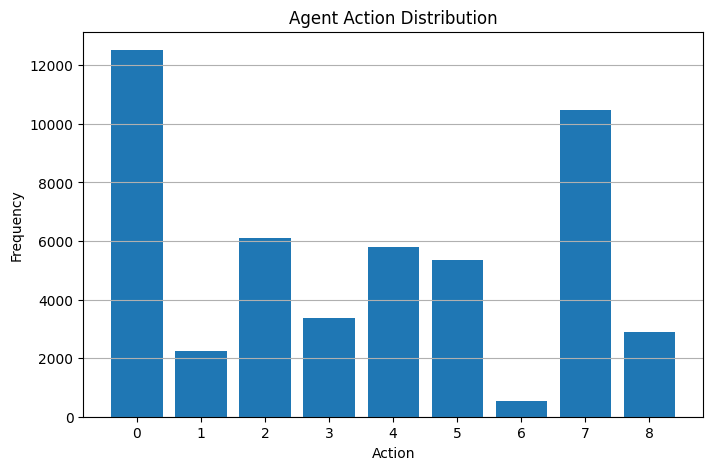

In [35]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()

Seed in the environment: 42
Seed in the environment: 42


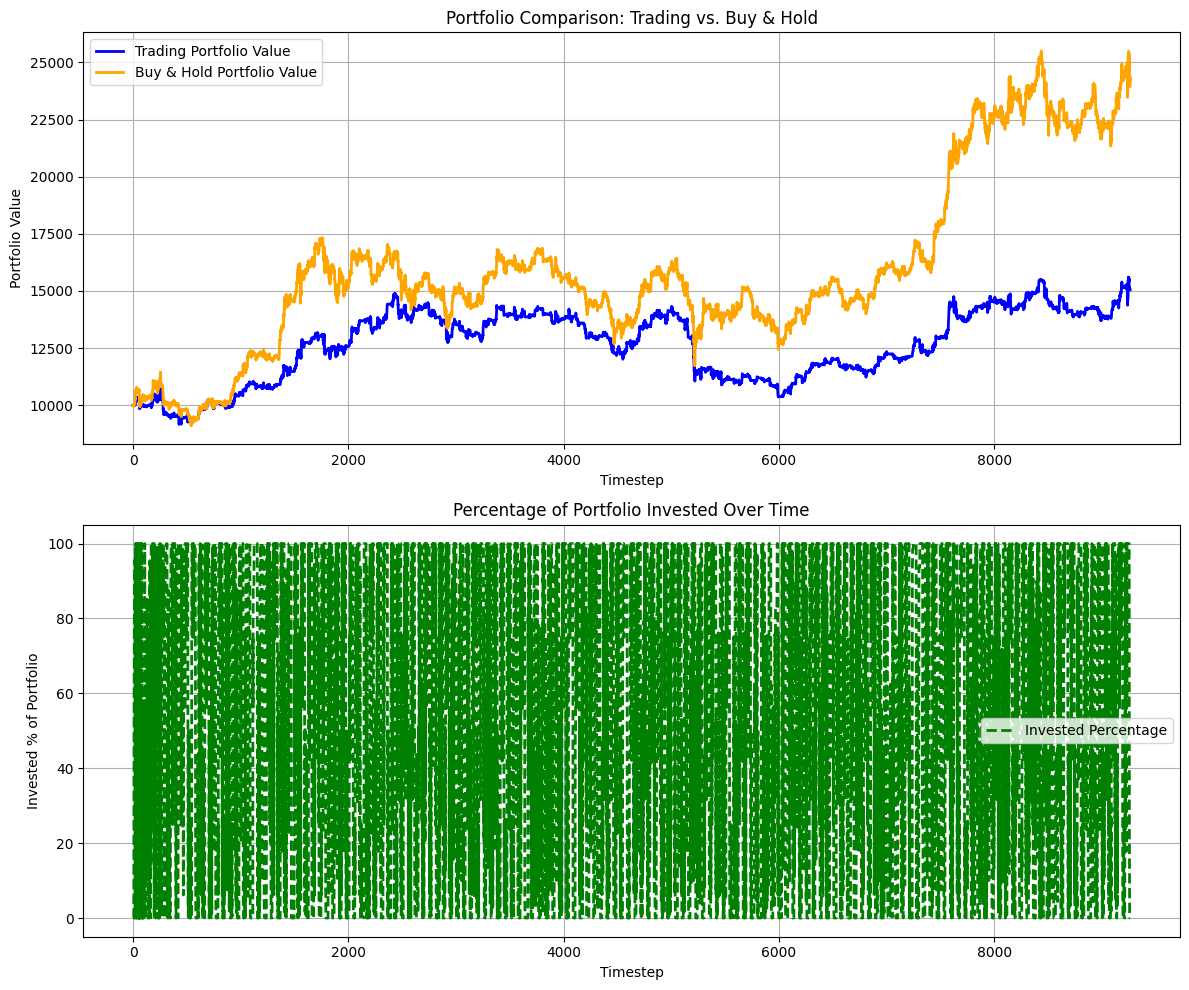

[0, 5, 0, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 3, 8, 8, 8, 8, 7, 7, 8, 8, 1, 4, 4, 4, 8, 3, 4, 4, 8, 3, 3, 8, 8, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 8, 1, 1, 8, 1, 1, 8, 8, 4, 8, 8, 1, 4, 8, 8, 8, 1, 8, 8, 8, 8, 7, 1, 8, 4, 4, 8, 8, 8, 8, 4, 8, 8, 8, 4, 8, 8, 7, 8, 1, 1, 8, 1, 1, 1, 8, 8, 8, 8, 1, 1, 8, 8, 8, 1, 1, 1, 8, 8, 1, 1, 1, 4, 7, 7, 8, 7, 8, 7, 6, 6, 6, 6, 8, 1, 1, 7, 1, 6, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 7, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 7, 2, 1, 2, 3, 6, 7, 1, 1, 2, 3, 8, 5, 3, 5, 7, 4, 4, 2, 2, 2, 2, 2, 2, 1, 2, 6, 2, 2, 2, 4, 7, 2, 1, 1, 6, 1, 1, 1, 1, 1, 4, 4, 2, 2, 8, 2, 2, 2, 2, 2, 3, 7, 6, 2, 2, 2, 6, 6, 8, 2, 2, 7, 7, 2, 2, 2, 2, 1, 2, 2, 6, 3, 3, 8, 6, 6, 6, 6, 6, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 8, 2, 4, 3, 3, 6, 3, 1, 1, 1, 3, 3, 1, 2, 6, 6, 6, 6, 6, 6, 6, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 8, 8, 7, 7, 2, 7, 0, 8, 8, 2, 2, 2, 7, 2, 2, 7, 7, 

In [36]:
# -------------------------------
# Testlauf: Den trainierten Agenten in einer Episode ausführen
# -------------------------------
test_env = TradingEnv(
    data=test_data,
    initial_cash=10_000,
    window_size=336,
    scaler_path="../../Transform_data/scaler.pkl",
    default_seed=SEED
)

obs, info = test_env.reset(seed=SEED)
done = False

# Liste der actionen
action_list = []

while not done:
    # Bestimme die Aktion (deterministisch)
    action, _states = model.predict(obs, deterministic=True)
    action = int(action)  # oder: action = action.item()
    obs, reward, done, truncated, info = test_env.step(action)
    action_list.append(action)

# Hier wird der Zustand gerendert (z.B. als Plot). Du kannst den Render-Modus anpassen.
test_env.render(mode='human')
print(action_list)

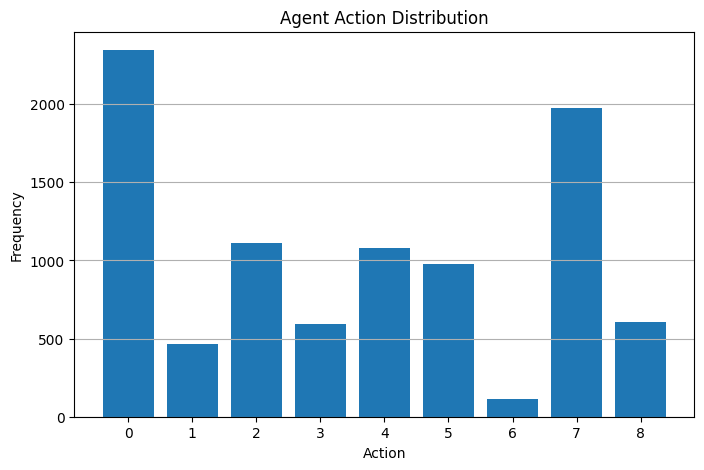

In [37]:

# -------------------------------
# Plot Action Distribution
# -------------------------------
action_counts = Counter(action_list)
actions = list(range(9))
counts = [action_counts.get(action, 0) for action in actions]

plt.figure(figsize=(8, 5))
plt.bar(actions, counts, tick_label=actions)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Agent Action Distribution")
plt.grid(axis='y')
plt.show()